## Particle Analysis
### Automatic calculations & graphing
#### Code Last updated on 2025-07-15 by Yinglin Li
##### (This is meant for protease activation events, otherwise the signmoid fitting is going to be wonky)
##### (This version **does not** need the XY file to work.)
______________________________________________________________________________
*7/14/25 - wrote code*
<br>
*7/15/25 - redid name outputs for excel + plots to include input file name*
_____________________________________________________________________________________________

#### Set user defined parameters

In [30]:
# Set filepath
    # Path to INTENSITY file
filepath1 = r"C:\Users\yli355\Downloads\2_3ROI1I.xls"
    # Path for OUTPUT file
filepath_out = r"C:\Users\yli355\Downloads"

# Time between frames (in seconds)
Tempres = 13

# Channel
YFP = 1
mCH = 3
FRET = 2

# nFRET Coefficients
YFP_BT = 0.01
mCH_BT = 0.05

# Pixel to um conversion (1 pixel = dim um)
Dim = 0.26820

# Sigmoid fitting time (set to None to use min/max values)
fit_x_min = 120
fit_x_max = None

#### Import Libraries

In [31]:
# #read in xls files, can remove if you already have it installed
# !pip install xlrd 
# # This one is for exporting to PDF
# !pip install nbconvert

In [32]:
# This cell can take longer on the first run

import pandas as pd 
import numpy as np 
import os

# sigmoid fitting stuff
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# for graphs
from matplotlib.collections import LineCollection
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

#### Read in files

In [33]:
df1 = pd.read_excel(filepath1, engine='xlrd', sheet_name=0, header=0)
df2 = pd.read_excel(filepath1, engine='xlrd', sheet_name=6, header=0)
df3 = pd.read_excel(filepath1, engine='xlrd', sheet_name=12, header=0)

In [34]:
# Get name of the file (using the intensity file, or whatever is filepath1
base_name = os.path.splitext(os.path.basename(filepath1))[0]

# Make output file names
summary_filename = f"{base_name}_Summary.xlsx"
nFRET_fit_img = f"{base_name}_nFRET_Fit.png"
CB_fit_img = f"{base_name}_CB_Fit.png"
intensity_img = f"{base_name}_intensity.png"

#### Calculate nFRET, Color Balance (CB), and output summary file

In [35]:
# Functions related to data cleaning
def correct_shift(df):
    """
    Function to align the values into a single column for when the final track is stitched together from multiple tracks.
    Shifts all columns except the first column (the column with frame numbers) to the left, aligning each row individually.
    
    After that, shifts all rows up by one.
    Finally, drops any columns that are all NaN.

    Parameters:
    - df (pd.DataFrame): The dataframe to be shifted
    
    Returns:
    - pd.DataFrame: DataFrame with left-shifted values (NaNs on the right), rows shifted up,
                    and all-NaN columns dropped
    """
    index_col = 0  # fixed index column

    # Extract the frame number column
    preserved_col = df.iloc[:, index_col]
    data_to_shift = df.drop(df.columns[index_col], axis=1)

    # Get shift value for rows
    n_shiftup = preserved_col.count() - df.shape[0]

    # Function to left-align a single row
    def left_align_row(row):
        non_nan_values = row.dropna().tolist()
        n_nans = len(row) - len(non_nan_values)
        return pd.Series(non_nan_values + [np.nan]*n_nans, index=row.index)

    # Apply left alignment row-wise
    shifted_data = data_to_shift.apply(left_align_row, axis=1)

    # Combine back with preserved column
    result_df = pd.concat([preserved_col, shifted_data], axis=1)

    # Set preserved column as index
    result_df.set_index(result_df.columns[0], inplace=True)

    # Shift up (drop first row, reindex) but keep all rows
    result_df = result_df.shift(n_shiftup)

    # Drop columns and rows that are all NaN
    result_df = result_df.dropna(axis=1, how='all')
    result_df = result_df.dropna(axis=0, how='all')

    return result_df

def rename_channels(df, YFP, FRET, mCH):
    """
    Renames the columns to 'YFP', 'FRET', and 'mCH' based on user-defined channel numbers.
 
    Parameters:
    - df (pd.DataFrame): DataFrame with at least 3 data columns (ignoring index)
    - YFP, FRET, mCH (int): Numbers assigned to each channel
    
    Returns:
    - pd.DataFrame: DataFrame with renamed columns
    """
    # Standardize the column names to A, B, C for easy mapping later on
    df.columns = ['A', 'B', 'C']

    # Build map from names based on position
    channel_labels = {YFP: 'YFP', FRET: 'FRET', mCH: 'mCH'}

    #Create list of new column names
    new_column_names = [channel_labels[i + 1] for i in range(3)]

    #Assign new column names
    df.columns = new_column_names

    return df

# Define sigmoid function
def sigmoid(x, L, k, x0, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Fit sigmoid function
def fit_and_report(df, x_col, y_col, fit_x_min=None, fit_x_max=None):
    """
    Fits sigmoid curve to a subset of data (defined by fit_x_min, fit_x_max),
    then predicts over the entire x range.
    
    Parameters:
    -----------
    df (pd.DataFrame): Input data.
    x_col (str): Column name for independent variable.
    y_col (str): Column name for dependent variable.
    fit_x_min (float, optional): Minimum x value to use for fitting.
    fit_x_max (float, optional): Maximum x value to use for fitting.
    
    Returns:
    --------
    results_df (pd.DataFrame): x_col, Predicted, Residual for full data.
    metrics_df (pd.DataFrame): Fit metrics (ec10, ec90, PR duration, MSE) from fit range.
    """

    x_data_all = df[x_col].values
    y_data_all = df[y_col].values

    # Select fitting range
    mask = np.ones_like(x_data_all, dtype=bool)
    if fit_x_min is not None:
        mask &= x_data_all >= fit_x_min
    if fit_x_max is not None:
        mask &= x_data_all <= fit_x_max

    x_data = x_data_all[mask]
    y_data = y_data_all[mask]

    # Initial guess and bounds
    initial_guess = [max(y_data) - min(y_data), 1, np.median(x_data), min(y_data)]
    bounds = (
        [0, 0, min(x_data), min(y_data) - 0.5 * abs(min(y_data))],
        [1.5 * (max(y_data) - min(y_data)), 5, max(x_data), max(y_data) + 0.5 * abs(max(y_data))]
    )

    try:
        popt, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, bounds=bounds)
        L, k, x0, b = popt

        # Predict over full x
        y_pred_all = sigmoid(x_data_all, *popt)
        residuals_all = y_data_all - y_pred_all
        mse = mean_squared_error(y_data, sigmoid(x_data, *popt))

        def calc_x_for_y(y_target):
            return x0 - (1 / k) * np.log((L / (y_target - b)) - 1)

        ec10 = calc_x_for_y(b + 0.1 * L)
        ec90 = calc_x_for_y(b + 0.9 * L)
        pr_duration = ec90 - ec10

        print(f"\n< {y_col} >")
        print(f"Fitting range: {fit_x_min} to {fit_x_max}")
        print(f"PR duration (ec90 - ec10): {pr_duration:.3f}")
        print(f"Mean Squared Error (fit range): {mse:.5f}\n")

    except Exception as e:
        print(f"\n< {y_col} >")
        print(f"Sigmoid fit failed for range {fit_x_min} to {fit_x_max}: {e}")
        print("Filling predicted/residuals with NaN.\n")

        y_pred_all = np.full_like(x_data_all, np.nan)
        residuals_all = np.full_like(x_data_all, np.nan)
        ec10 = ec90 = pr_duration = mse = np.nan

    results_df = pd.DataFrame({
        x_col: x_data_all,
        'Predicted': y_pred_all,
        'Residual': residuals_all
    })

    metrics_df = pd.DataFrame({
        'ec10': [ec10],
        'ec90': [ec90],
        'PR duration': [pr_duration],
        'MSE': [mse]
    })

    return results_df, metrics_df

In [36]:
# Correct for any issues from stitching
ch1 = correct_shift(df1)
ch2 = correct_shift(df2)
ch3 = correct_shift(df3)
#ch1.shape == ch2.shape == ch3.shape # This should return true

# Combine datasets (intensity files only)
df = pd.concat([ch1, ch2, ch3],axis=1)
#ch1.shape[0] == df.shape[0] # This should return true

# Rename columns to YFP, FRET, mCH according to user inputs
df = rename_channels(df, YFP, FRET, mCH)

# Calculate Time in minutes and seconds
df['Time (sec)'] = df.index * Tempres
df['Time (min)'] = df.index * Tempres / 60

# Calculate nFRET
df['nFRET'] = (df['FRET'] - (YFP_BT * df['YFP']) - (mCH_BT * df['mCH'])) / df['mCH']

# Calculate Color Balance
df['CB'] = df['YFP'] / (df['YFP'] + df['mCH'])

# reorder columns for readability reasons
df = df.iloc[:, [3,4,0,2,1,5,6]] 

#### Sigmoid fitting of nFRET and CB

In [37]:
results_nFRET, metrics_nFRET = fit_and_report(df, 'Time (min)', 'nFRET', fit_x_min=fit_x_min, fit_x_max=fit_x_max) # Max cannot go beyond max time

results_CB, metrics_CB = fit_and_report(df, 'Time (min)', 'CB', fit_x_min=fit_x_min, fit_x_max=fit_x_max)

# Note: You want the lowest mean squared error possible


< nFRET >
Sigmoid fit failed for range 120 to None: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Filling predicted/residuals with NaN.


< CB >
Fitting range: 120 to None
PR duration (ec90 - ec10): 11.587
Mean Squared Error (fit range): 0.00093



##### Compile and save output in a summary excel file

In [38]:
# add in predicted and residuals for nFRET and CB to df file

# Columns to be added or replaced
columns_to_drop = [
    'predicted nFRET', 'residual nFRET',
    'predicted CB', 'residual CB'
]

# Drop existing columns if they already exist
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Clean nFRET results
results_nFRET = results_nFRET.drop(columns=['Time (min)'], errors='ignore')
results_nFRET = results_nFRET.rename(columns={
    'Predicted': 'predicted nFRET',
    'Residual': 'residual nFRET'
})

# Clean CB results
results_CB = results_CB.drop(columns=['Time (min)'], errors='ignore')
results_CB = results_CB.rename(columns={
    'Predicted': 'predicted CB',
    'Residual': 'residual CB'
})

# Combine with main df
df = pd.concat([df, results_nFRET, results_CB], axis=1)

# Create kinetics summary
metrics_nFRET.index = ['nFRET']
metrics_CB.index = ['CB']
kinetics = pd.concat([metrics_nFRET, metrics_CB])

In [39]:
# Save output
filepath = os.path.join(filepath_out, f"{base_name}_Summary.xlsx")

with pd.ExcelWriter(filepath) as writer:
    df.to_excel(writer, sheet_name='Summary', index=True)
    kinetics.to_excel(writer, sheet_name='Kinetics', index=True)

#### Graphs

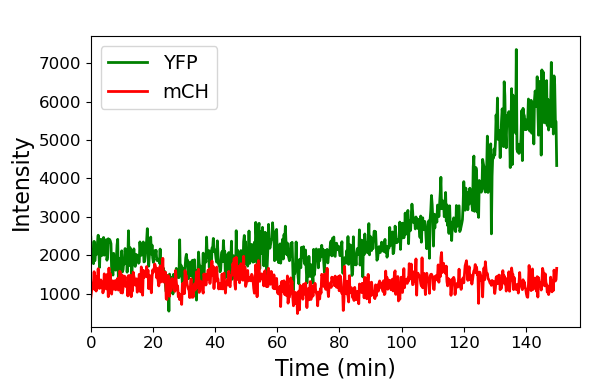

In [40]:
# Intensity plot
color_YFP = 'green' 
color_mCH = 'red'  

plt.figure(figsize=(6,4))
plt.plot(df['Time (min)'], df['YFP'], label='YFP', color=color_YFP, linewidth=2)
plt.plot(df['Time (min)'], df['mCH'], label='mCH', color=color_mCH, linewidth=2)

plt.xlabel('Time (min)', fontsize=16)       # X-axis label size
plt.ylabel('Intensity', fontsize=16)  # Y-axis label size
plt.title(' ', fontsize=16)       # Title size
plt.legend(fontsize=14)                      # Legend text size
plt.tick_params(axis='both', which='major', labelsize=12)  # Tick labels size

plt.xlim(left=0)
plt.grid(False)
plt.tight_layout()
save_path = os.path.join(filepath_out, f"{base_name}_intensity.png")
plt.savefig(save_path, dpi=300)
plt.show()

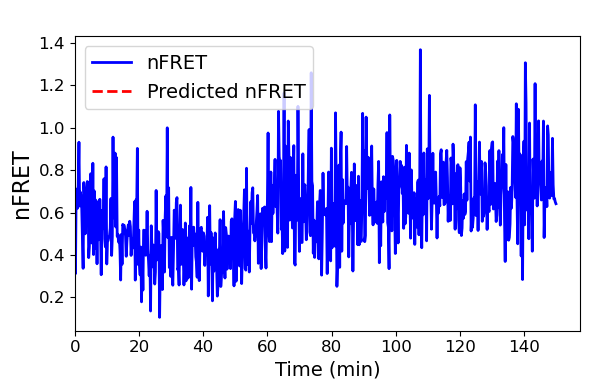

In [41]:
# Sigmoid fit of nFRET
plt.figure(figsize=(6,4))
plt.plot(df['Time (min)'], df['nFRET'], label='nFRET', color='blue', linewidth=2)
plt.plot(df['Time (min)'], df['predicted nFRET'], label='Predicted nFRET', color='red', linewidth=2, linestyle='--')

plt.xlabel('Time (min)', fontsize=14)
plt.ylabel('nFRET', fontsize=16)
plt.title(' ', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlim(left=0) # can redo to left=100 to start at min=100, or xlim(10,20) to only plot 10 to 20 min
plt.grid(False)
plt.tight_layout()
save_path = os.path.join(filepath_out, f"{base_name}_nFRET_Fit.png")
plt.savefig(save_path, dpi=300)
plt.show()

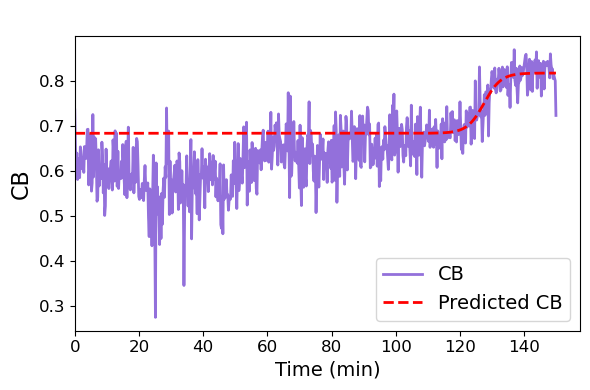

In [42]:
# Sigmoid fit of CB
plt.figure(figsize=(6,4))
plt.plot(df['Time (min)'], df['CB'], label='CB', color='mediumpurple', linewidth=2)
plt.plot(df['Time (min)'], df['predicted CB'], label='Predicted CB', color='red', linewidth=2, linestyle='--')

plt.xlabel('Time (min)', fontsize=14)
plt.ylabel('CB', fontsize=16)
plt.title(' ', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlim(left=0) # can redo to left=100 to start at min=100, or xlim(10,20) to only plot 10 to 20 min
plt.grid(False)
plt.tight_layout()
save_path = os.path.join(filepath_out, f"{base_name}_CB_Fit.png")
plt.savefig(save_path, dpi=300)
plt.show()